## b988 - 20/10/2016 - VANAHEIM - Trapped Lee Wave

During this flight the FAAM aircraft was flying downwind of the Snaefellsnes Peninsula on the West Coast of Iceland. The aircraft data are compared with WRF model results. The variable that is compared is the vertical wind speed. We compare the data for a set of runs when the aircraft was flying at ~750mb altitude.

In [1]:
%matplotlib inline

import os

ROOT_DATA_PATH = '/home/axel/Dropbox/cis_workshop/data/b988'

os.chdir(ROOT_DATA_PATH)

The WRF vertical wind speed variable has been extracted and converted into netCDF.

w / (1)                             (latitude: 300; longitude: 320; times: 119)
     Dimension coordinates:
          latitude                           x               -           -
          longitude                          -               x           -
          times                              -               -           x


/usr/local/lib/python2.7/dist-packages/Iris-1.12.0.dev0-py2.7.egg/iris/analysis/cartography.py:376: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")
/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


(63.5, 68.0)

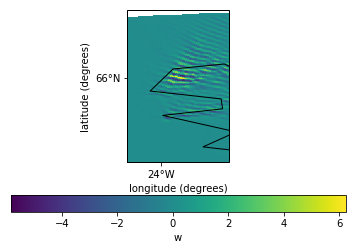

In [2]:
# Read in the wrf model data set
import cis 
wrf = cis.read_data('b988_wrf_w_750mb.nc', 'w')
print(wrf)

# Average over all timestamps. The waves were stationary for the whole run
wrf_avg = wrf.collapsed('times', how='mean')
ax = wrf_avg.plot()
# Zoom into the area of interest
ax.set_xlim((-25, -22))
ax.set_ylim((63.5, 68.0))

### Preparing the aircraft data

For this example we like to work with the high resolution data and not just the 1Hz data. To do that we need to get rid off the sps dimensions of the FAAM core netCDF and flatten it, so that the only remaining dimension is Time. We use a combination of pandas and xarray to create a new netCDF.

In [3]:
import xarray as xr
import pandas as pd
import numpy as np
import netCDF4

OVERWRITE_NETCDF = False

# Open the FAAM core netCDF
core = xr.open_dataset('core_faam_20161020_v004_r0_b988.nc')

# List of variables that we gonna to extract from the high
# resolution FAAM core netCDF. All those variables are available at 32Hz
var_names = ['LON_GIN',
             'LAT_GIN',
             'ALT_GIN',
             'U_C',
             'V_C',
             'W_C',
             'PS_RVSM']

# This are the units for the time coordinate
_units = "seconds since 2016-10-20 00:00:00 +0000"

# Now the panda magic begins.
# Creating a high resolution time array using panda magic
# The time step is 1./32. seconds, which equals 31250 microseconds.
t2 = pd.date_range(start=pd.Timestamp(core.Time.data.min()).to_pydatetime(),
                   periods=core.Time.size*32,
                   freq='31250U')

# Convert it back to seconds after midnight using the date2num method from netCDF4
secs = [netCDF4.date2num(t, units=_units) for t in t2]

# The netCDF will be created from a dictionary. Start with an empty dictionary
d = {}

# Create the Time variable using
d['Time'] = {'dims': ('Time', ), 'data': secs, 'attrs': core.Time.attrs}
d['Time']['attrs']['calendar'] = 'gregorian'
d['Time']['attrs']['units'] = _units
# Add all the parameters one after another
for var_name in var_names:
    data = core[var_name].data.flatten()[:]
    # get rid off nan values
    data[~np.isfinite(data)] = -9999.
    # flag all data '0' GIN data as -9999.
    if 'GIN' in var_name:
        data[data == 0.] = -9999.
    d[var_name] = {'dims': ('Time', ), 'data': data, 'attrs': core[var_name].attrs}    
    d[var_name]['attrs']['_FillValue'] = -9999. # Define the FillValue
    
# Adding standard name to the static pressure
d['PS_RVSM']['attrs']['standard_name'] = 'pressure_level'

# Convert the dictionary to dataset
ds = xr.Dataset.from_dict(d)

# Adding the global attributes that are necessary, so that cis recognises
# the netCDF as aircraft data
ds.attrs['Convention'] = "NCAR-RAF/nimbus"
ds.attrs['Coordinates'] = "LON_GIN LAT_GIN ALT_GIN Time"

# Write it out to disk
ofile = os.path.join(ROOT_DATA_PATH, 'b988_core_flattened.nc')

if (os.path.exists(ofile) and OVERWRITE_NETCDF):
    os.remove(ofile)

# Write the dataset to netCDF
if not os.path.exists(ofile):
    ds.to_netcdf(path=ofile)

### Working with cis

Now that we made it that far we can load the newly created netCDF with cis.

In [4]:
ara = cis.read_data('b988_core_flattened.nc', 'W_C', product='NCAR_NetCDF_RAF')
print(ara)

Ungridded data: W_C / (m s-1) 
     Shape = (346952,)

     Total number of points = 346952
     Number of non-masked points = 329980
     Long name = Vertical wind component from turbulence probe and GIN
     Standard name = upward_air_velocity
     Units = m s-1
     Missing value = -9999.0
     Range = (-7189.03515625, 9.3809890747070312)
     History = 
     Misc attributes: 
       _Fillvalue = -9999.0
       Frequency = 32
       Type = Data
       Number = 716
     Coordinates: 
       Time
          Long name = time of measurement
          Standard name = time
          Units = days since 1600-01-01 00:00:00
          Missing value = None
          Range = (2016-10-20 08:43:43.124985, 2016-10-20 11:44:25.343747)
          History = 
          Misc attributes: 
            Calendar = gregorian
       LAT_GIN
          Long name = Latitude from POS AV 510 GPS-aided Inertial Navigation unit
          Standard name = latitude
          Units = degree_north
          Missing value 

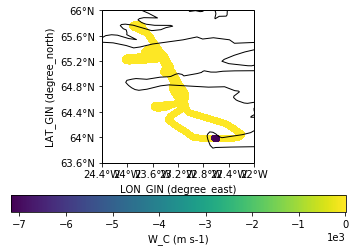

In [5]:
ara.plot()

In [6]:
# There are some errorenous data in the data set, which screws up the data range
ara.data.mask[np.abs(ara.data) > 10] = True

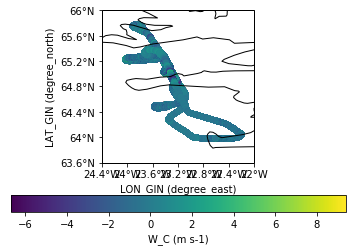

In [7]:
ara.plot()

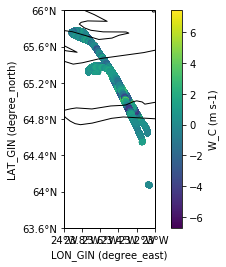

In [8]:
# Subsetting the data for a specific height range, which equals roughly 
# the 750mb level from the WRF model
ara_sub = ara.subset(z=[2280, 2360])
ara_sub.plot()

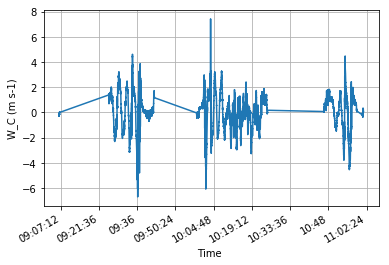

In [10]:
# And plot it as a time series to see wave structure in the vertical
# wind component
ax = ara_sub.plot(xaxis='time')
ax.grid(True)

In [ ]:
# TODO: collocating with wrf and comparing model with aircraft measurements